### Importing Libraries

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import torch
from torch.utils.data import Subset, ConcatDataset


### Creating and Processing my Dataset from VGG_Face2

In [2]:
dataset_path = '../1/'  # Adjust this to your actual path
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

In [3]:
"""
def create_pairs(data_path, num_pairs=1000):
    pairs = []
    labels = []

    # Get a list of all person folders and shuffle them for variety
    person_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    random.shuffle(person_dirs)  # Shuffle the folders for a more random selection

    # Calculate approximate number of pairs per person for positive pairs
    pairs_per_person = max(1, num_pairs // (2 * len(person_dirs)))

    # Create positive pairs (same person)
    for person in person_dirs:
        images = os.listdir(os.path.join(data_path, person))
        if len(images) < 2:
            continue  # Skip if not enough images to form pairs

        # Shuffle images for each person to increase randomness
        random.shuffle(images)

        # Generate positive pairs, ensuring each folder contributes some pairs
        for _ in range(pairs_per_person):
            if len(images) < 2:
                break  # Break if not enough images to sample
            img1, img2 = random.sample(images, 2)
            pairs.append((os.path.join(data_path, person, img1),
                          os.path.join(data_path, person, img2)))
            labels.append(0)  # Label 0 for same person

    # Shuffle persons again to create more variety in negative pairs
    random.shuffle(person_dirs)

    # Create negative pairs (different persons)
    for _ in range(num_pairs - len(pairs)):  # Fill remaining pairs as negative
        person1, person2 = random.sample(person_dirs, 2)  # Pick two different persons
        img1 = random.choice(os.listdir(os.path.join(data_path, person1)))
        img2 = random.choice(os.listdir(os.path.join(data_path, person2)))
        pairs.append((os.path.join(data_path, person1, img1),
                      os.path.join(data_path, person2, img2)))
        labels.append(1)  # Label 1 for different persons

    # Shuffle the final pairs list to mix positive and negative pairs
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)

    return pairs, labels
"""

'\ndef create_pairs(data_path, num_pairs=1000):\n    pairs = []\n    labels = []\n\n    # Get a list of all person folders and shuffle them for variety\n    person_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]\n    random.shuffle(person_dirs)  # Shuffle the folders for a more random selection\n\n    # Calculate approximate number of pairs per person for positive pairs\n    pairs_per_person = max(1, num_pairs // (2 * len(person_dirs)))\n\n    # Create positive pairs (same person)\n    for person in person_dirs:\n        images = os.listdir(os.path.join(data_path, person))\n        if len(images) < 2:\n            continue  # Skip if not enough images to form pairs\n\n        # Shuffle images for each person to increase randomness\n        random.shuffle(images)\n\n        # Generate positive pairs, ensuring each folder contributes some pairs\n        for _ in range(pairs_per_person):\n            if len(images) < 2:\n                break  # Brea

In [4]:

"""
# Generate training pairs
train_pairs, train_labels = create_pairs(train_path, num_pairs=2000000)
# Generate validation pairs
val_pairs, val_labels = create_pairs(val_path, num_pairs=500000)
"""

'\n# Generate training pairs\ntrain_pairs, train_labels = create_pairs(train_path, num_pairs=2000000)\n# Generate validation pairs\nval_pairs, val_labels = create_pairs(val_path, num_pairs=500000)\n'

In [5]:
"""


def save_pairs_to_sqlite(pairs, labels, db_file):
    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    
    # Create table if it doesn't exist
    c.execute('''
        CREATE TABLE IF NOT EXISTS image_pairs (
            image1 TEXT,
            image2 TEXT,
            label INTEGER
        )
    ''')

    # Insert data into the table
    c.executemany('INSERT INTO image_pairs (image1, image2, label) VALUES (?, ?, ?)', 
                  [(pair[0], pair[1], label) for pair, label in zip(pairs, labels)])

    conn.commit()
    conn.close()


"""

"\n\n\ndef save_pairs_to_sqlite(pairs, labels, db_file):\n    conn = sqlite3.connect(db_file)\n    c = conn.cursor()\n    \n    # Create table if it doesn't exist\n    c.execute('''\n        CREATE TABLE IF NOT EXISTS image_pairs (\n            image1 TEXT,\n            image2 TEXT,\n            label INTEGER\n        )\n    ''')\n\n    # Insert data into the table\n    c.executemany('INSERT INTO image_pairs (image1, image2, label) VALUES (?, ?, ?)', \n                  [(pair[0], pair[1], label) for pair, label in zip(pairs, labels)])\n\n    conn.commit()\n    conn.close()\n\n\n"

In [6]:
"""

save_pairs_to_sqlite(train_pairs, train_labels, 'train_pairs.db')
save_pairs_to_sqlite(val_pairs, val_labels, 'val_pairs.db')

"""

"\n\nsave_pairs_to_sqlite(train_pairs, train_labels, 'train_pairs.db')\nsave_pairs_to_sqlite(val_pairs, val_labels, 'val_pairs.db')\n\n"

### Creating custom Model

In [7]:
# Instantiate model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Element-wise addition for residual connection
        return self.relu(out)



In [9]:

import torch.nn.functional as F



class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding=3, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=7, padding=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=7, padding=3, stride=2)
       
        
        
        # Additional convolution layers
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
       

        # Adding two more convolutional layers
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)  # New conv layer 1
        self.conv8 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)  # New conv layer 1
        
        self.conv9 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1)  # New conv layer 2
        

        self.conv10 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1)  # New conv layer 2
        self.conv11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)  # New conv layer 2
        self.bn3 = nn.BatchNorm2d(512)

        # Residual blocks with appropriate downsampling
        self.res_block1 = ResidualBlock(512, 512)
        self.res_block2 = ResidualBlock(512, 512)

        # Pooling layer after all convolutions (adjust pooling here for final spatial dimensions)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 2048)
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout_fc1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)
        self.dropout_fc2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(1024, 512)  
        self.dropout_fc3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(512, 256)  
        self.dropout_fc4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(256, 128)  # Embedding size


    def forward_one(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2)

        # Additional convolution layers
        x = self.conv4(x)
        x = self.bn2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2)

        # New convolutional layers
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.relu(x)
        

        x = self.conv10(x)
        x = self.conv11(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        # Pass through residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)

        # Global average pooling to obtain fixed-size feature maps (4x4 output)
        x = self.global_avg_pool(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Pass through the fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        #x = self.dropout_fc1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.relu(x)
        #x = self.dropout_fc2(x)

        x = self.fc3(x)  # Output embeddings
        #x = self.dropout_fc3(x)
        x = self.fc4(x)  # Output embeddings
        #x = self.dropout_fc4(x)
        x = self.fc5(x)  # Output embeddings
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


In [10]:
class SiameseDataset(Dataset):
    def __init__(self, db_file, transform=None):
        self.transform = transform
        self.pairs = self.load_pairs(db_file)

    def load_pairs(self, db_file):
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query("SELECT image1, image2, label FROM image_pairs", conn)
        conn.close()
        return list(zip(df['image1'], df['image2'], df['label']))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        
        # Load images
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [11]:
# Define contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss


### Training My custom Model

In [12]:

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is grayscale
    #transforms.GaussianBlur(kernel_size=5, sigma=0.2),  # Apply Gaussian blur with sigma=0.2
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize grayscale images (adjust the values as needed)
])


In [13]:

# Load the datasets with transforms
train_dataset = SiameseDataset('train_pairs.db', transform=transform)
val_dataset = SiameseDataset('val_pairs.db', transform=transform)
len(train_dataset)


100000

In [14]:
"""
import matplotlib.pyplot as plt
from collections import Counter

# Assuming labels can be accessed with dataset[i][1] (adjust if different)
def get_label_counts(dataset):
    labels = [dataset[i][2] for i in range(len(dataset))]
    label_counts = Counter(labels)
    return label_counts

# Get label counts for the combined dataset
label_counts = get_label_counts(val_dataset)

# Calculate ratios
total = sum(label_counts.values())
label_ratios = {label: count / total for label, count in label_counts.items()}

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(label_ratios.keys(), label_ratios.values(), color=['blue', 'orange'])
plt.xticks([0, 1], labels=['Match', 'No Match'])
plt.xlabel("Labels")
plt.ylabel("Ratio")
plt.title("Ratio of 0 and 1 in Labels")
plt.show()
"""


'\nimport matplotlib.pyplot as plt\nfrom collections import Counter\n\n# Assuming labels can be accessed with dataset[i][1] (adjust if different)\ndef get_label_counts(dataset):\n    labels = [dataset[i][2] for i in range(len(dataset))]\n    label_counts = Counter(labels)\n    return label_counts\n\n# Get label counts for the combined dataset\nlabel_counts = get_label_counts(val_dataset)\n\n# Calculate ratios\ntotal = sum(label_counts.values())\nlabel_ratios = {label: count / total for label, count in label_counts.items()}\n\n# Plotting\nplt.figure(figsize=(6, 4))\nplt.bar(label_ratios.keys(), label_ratios.values(), color=[\'blue\', \'orange\'])\nplt.xticks([0, 1], labels=[\'Match\', \'No Match\'])\nplt.xlabel("Labels")\nplt.ylabel("Ratio")\nplt.title("Ratio of 0 and 1 in Labels")\nplt.show()\n'

In [15]:

# Create dataloaders
batch_size = 512  # Adjust according to your GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)


### Loading model from save

In [16]:
model = SiameseNetwork().to(device)
# Load the state dictionary (trained parameters) into the model
model.load_state_dict(torch.load("FR_model.pth"))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

print("Model loaded successfully.")
model

Model loaded successfully.


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(2048, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [17]:
# Instantiate model, loss function, and optimizer
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
def validate_model():
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            running_val_loss += loss.item()

    print(f"Validation Loss: {running_val_loss/len(val_loader):.4f}")

In [19]:
# Training loop
def train_model(num_epochs=100):
    for epoch in range(num_epochs):
        subepoch=0
        model.train()
        running_loss = 0.0
        for img1, img2, label in combined_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            subepoch+=1
            #print(f"Epoch [{epoch+1}]:subepoch [{subepoch}/{len(combined_loader)}], Loss: {loss.item()}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(combined_loader):.4f}")
        
       

In [20]:
train_model(num_epochs=100)

Epoch [1/100], Loss: 0.3274
Epoch [2/100], Loss: 0.3255
Epoch [3/100], Loss: 0.3210
Epoch [4/100], Loss: 0.3207
Epoch [5/100], Loss: 0.3194
Epoch [6/100], Loss: 0.3185
Epoch [7/100], Loss: 0.3173
Epoch [8/100], Loss: 0.3148


KeyboardInterrupt: 

In [21]:
validate_model()

Validation Loss: 0.2776


### Saving and Loading Model

In [22]:
# Specify the path where the model will be saved
model_save_path = "FR_model.pth"

# Save the model's state dictionary (this contains the trained parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to FR_model.pth


### Testing The model with Real Imaged

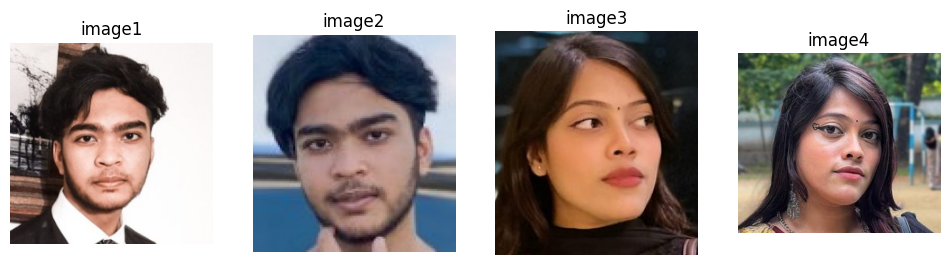

In [23]:
# Load images individually
image1 = Image.open('rafid1.jpg').convert('RGB')
image2 = Image.open('rafid2.jpg').convert('RGB')
image3 = Image.open('rathri1.jpg').convert('RGB')
image4 = Image.open('rathri2.jpg').convert('RGB')

# Display the images using matplotlib
plt.figure(figsize=(12, 6))

# Show Image 1
plt.subplot(1, 4, 1)
plt.imshow(image1)
plt.title('image1')
plt.axis('off')

# Show Image 2
plt.subplot(1, 4, 2)
plt.imshow(image2)
plt.title('image2')
plt.axis('off')

# Show Image 3
plt.subplot(1, 4, 3)
plt.imshow(image3)
plt.title('image3')
plt.axis('off')

# Show Image 4
plt.subplot(1, 4, 4)
plt.imshow(image4)
plt.title('image4')
plt.axis('off')

plt.show()

In [24]:

def predict_similarity(siamese_network, image1, image2, threshold=0.5):

   # Define the transformations
    # Define the transformations
    transform = transforms.Compose([
                transforms.Resize((128, 128)),  # Resize images to a fixed size
                transforms.Grayscale(num_output_channels=1),  # Ensure the image is grayscale
                transforms.GaussianBlur(kernel_size=5, sigma=0.2),  # Apply Gaussian blur with sigma=0.2
                transforms.ToTensor(),  # Convert images to PyTorch tensors
                transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize grayscale images (adjust the values as needed)
])
    image1 = transform(image1).unsqueeze(0).to(device)  # Add batch dimension and move to device
    image2 = transform(image2).unsqueeze(0).to(device)

    # Ensure the model is in evaluation mode
    siamese_network.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Pass both images through the Siamese Network
        output1, output2 = siamese_network(image1, image2)
        
        # Calculate the Euclidean distance between the embeddings
        distance =torch.nn.functional.pairwise_distance(output1, output2)
        
        # Check if the distance is less than the threshold
        if distance.item() < threshold:
            return True  # Images are of the same person
        else:
            return False  # Images are of different people


In [25]:
#should be true
print(predict_similarity(model, image1, image2, threshold=0.5))
print(predict_similarity(model, image3, image4, threshold=0.5))
print("\n")
#should be False
print(predict_similarity(model, image1, image4, threshold=0.5))
print(predict_similarity(model, image2, image3, threshold=0.5))
print(predict_similarity(model, image1, image3, threshold=0.5))
print(predict_similarity(model, image2, image4, threshold=0.5))


True
True


False
False
False
False


### Visualizing My cnn layers

In [26]:
import matplotlib.pyplot as plt
import torch
from torch import nn

def plot_cnn_layer_activations(model, input_image, layer_names=None):
    """
    Visualizes the feature maps (activations) from CNN layers in the model.
    
    Args:
        model: An instance of the Siamese network.
        input_image: A single input image tensor (shape: 1xCxHxW).
        layer_names: List of layer names to visualize. If None, all CNN layers are visualized.
    """
    activations = []
    hooks = []

    def hook_fn(module, input, output):
        activations.append(output)

    # Select layers for visualization
    layers_to_visualize = layer_names or [name for name, _ in model.named_children()]

    # Register hooks on the specified layers
    for name, layer in model.named_children():
        if name in layers_to_visualize:
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)
    
    # Forward pass the image through the network
    with torch.no_grad():
        model.forward_one(input_image)

    # Visualize the feature maps
    for i, activation in enumerate(activations):
        activation = activation.squeeze(0)  # Remove batch dimension
        num_features = activation.size(0)
        grid_size = int(num_features**0.5)
        
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle(f"Activations of Layer {i + 1}: {layers_to_visualize[i]}", fontsize=16)
        
        for j in range(min(grid_size**2, num_features)):  # Limit to grid size
            ax = axs[j // grid_size, j % grid_size]
            ax.imshow(activation[j].cpu().numpy(), cmap='viridis')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    # Remove hooks
    for hook in hooks:
        hook.remove()


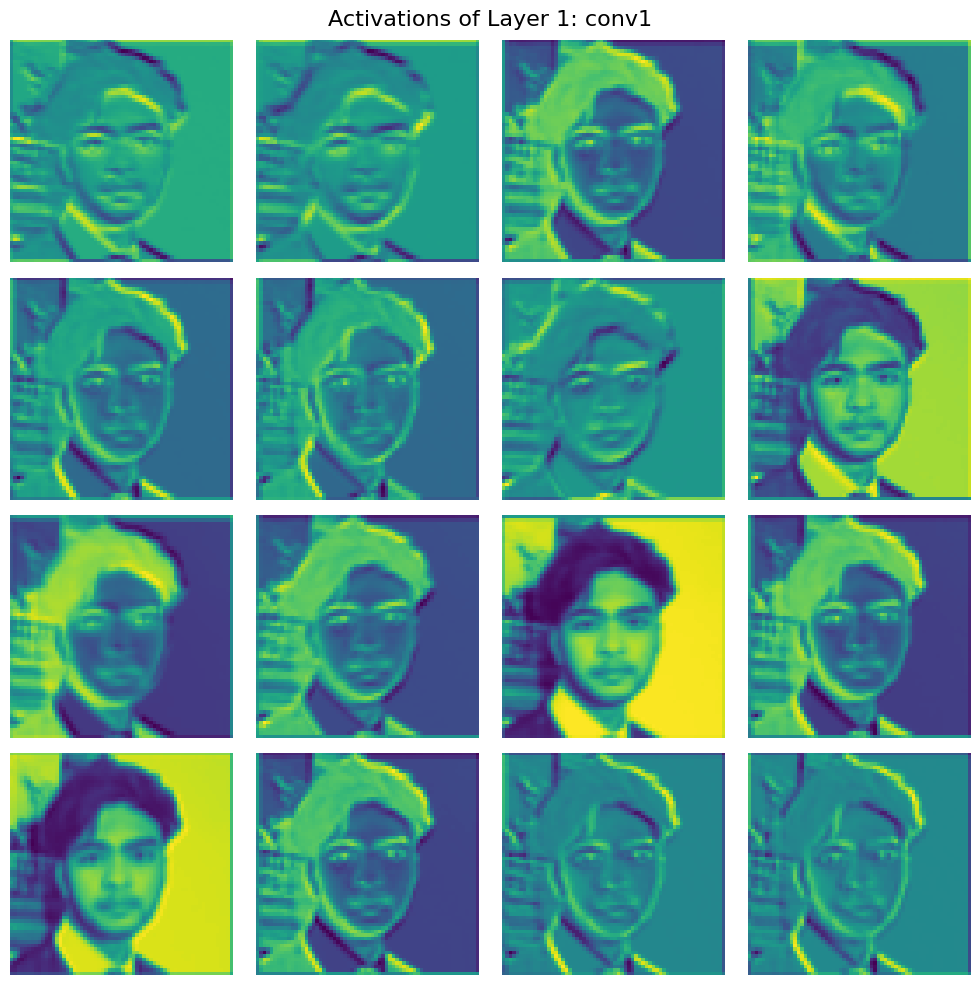

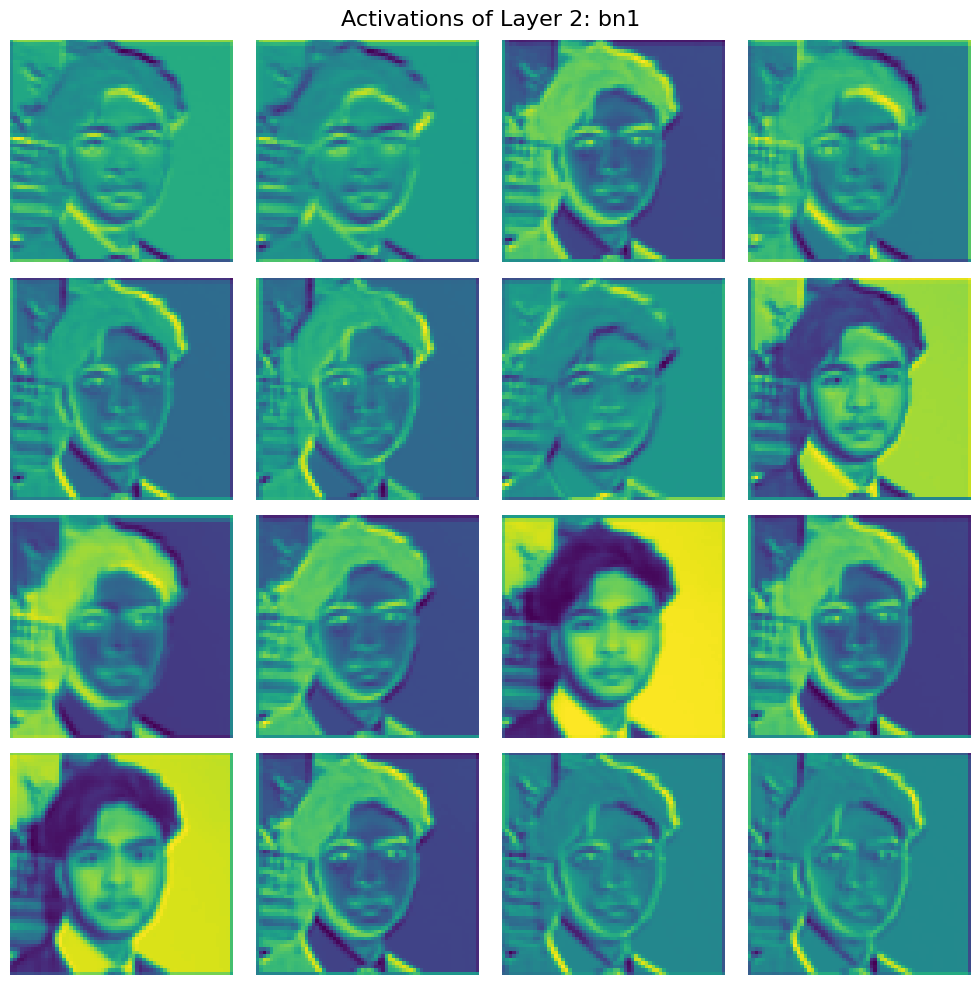

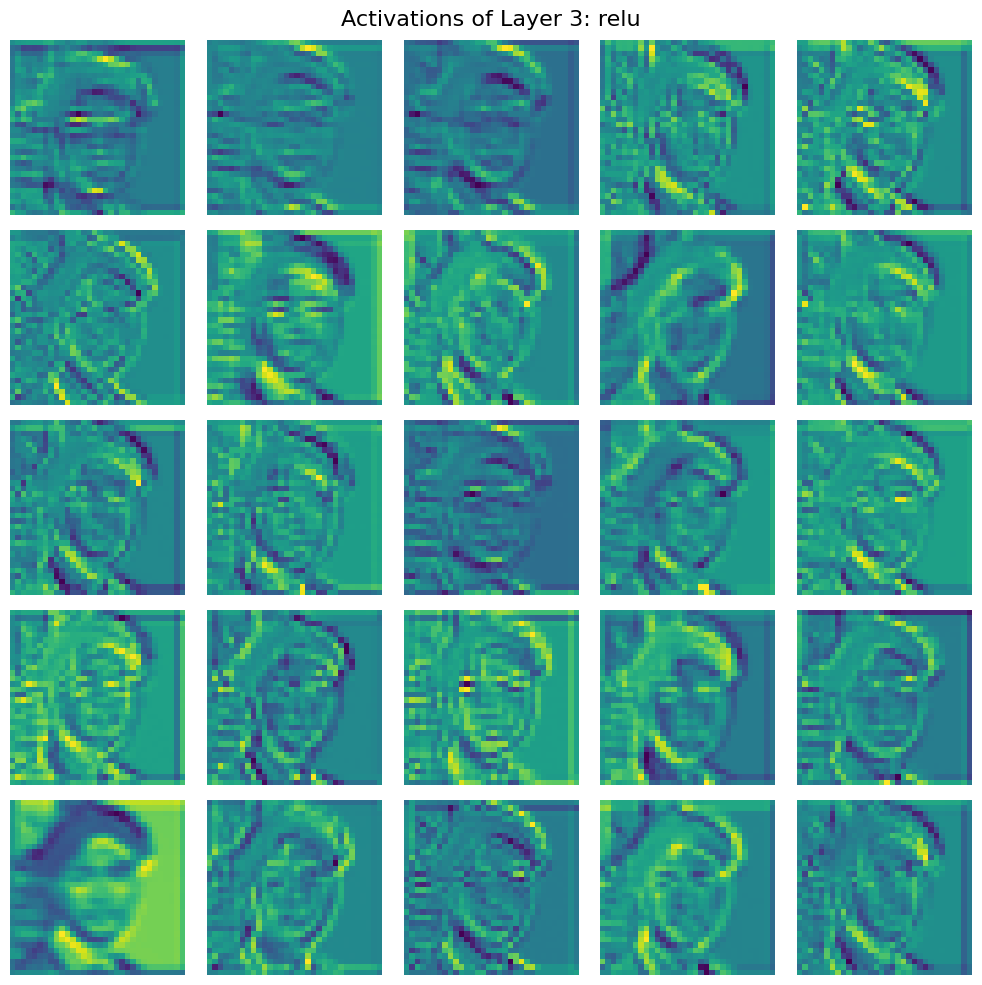

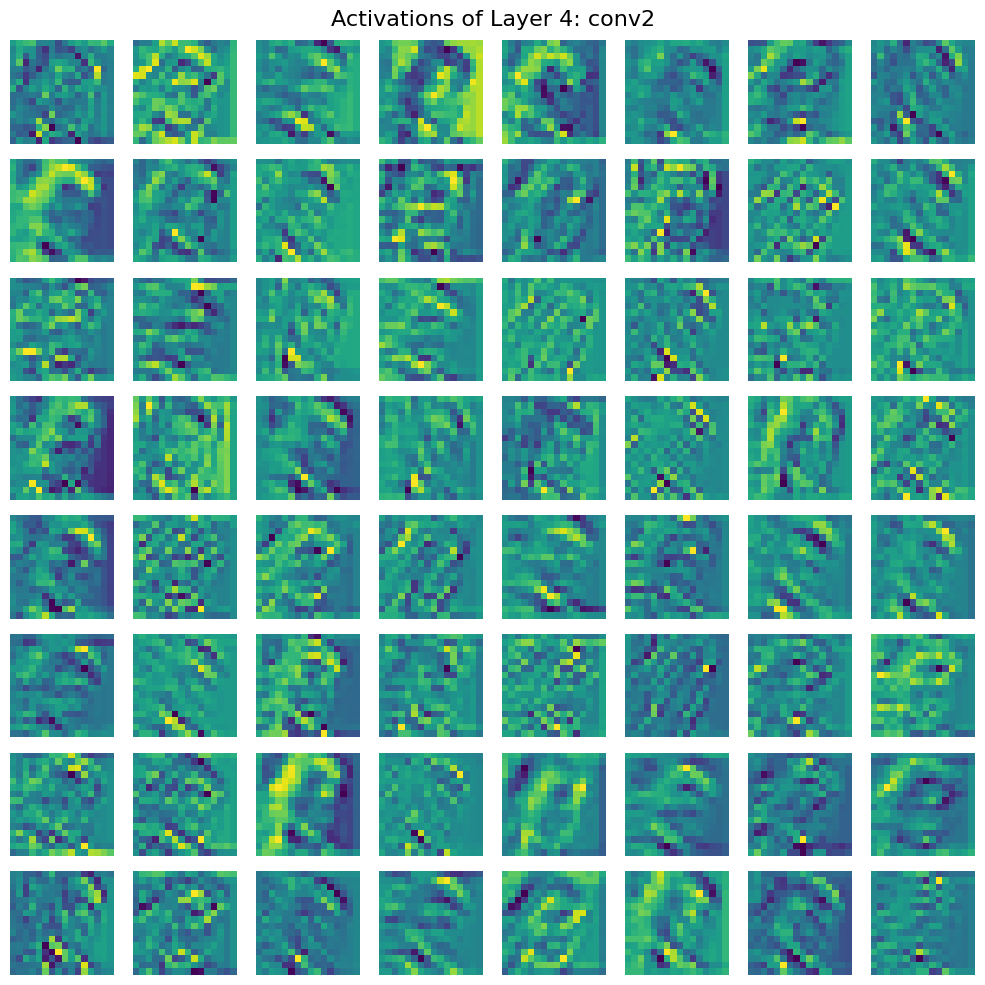

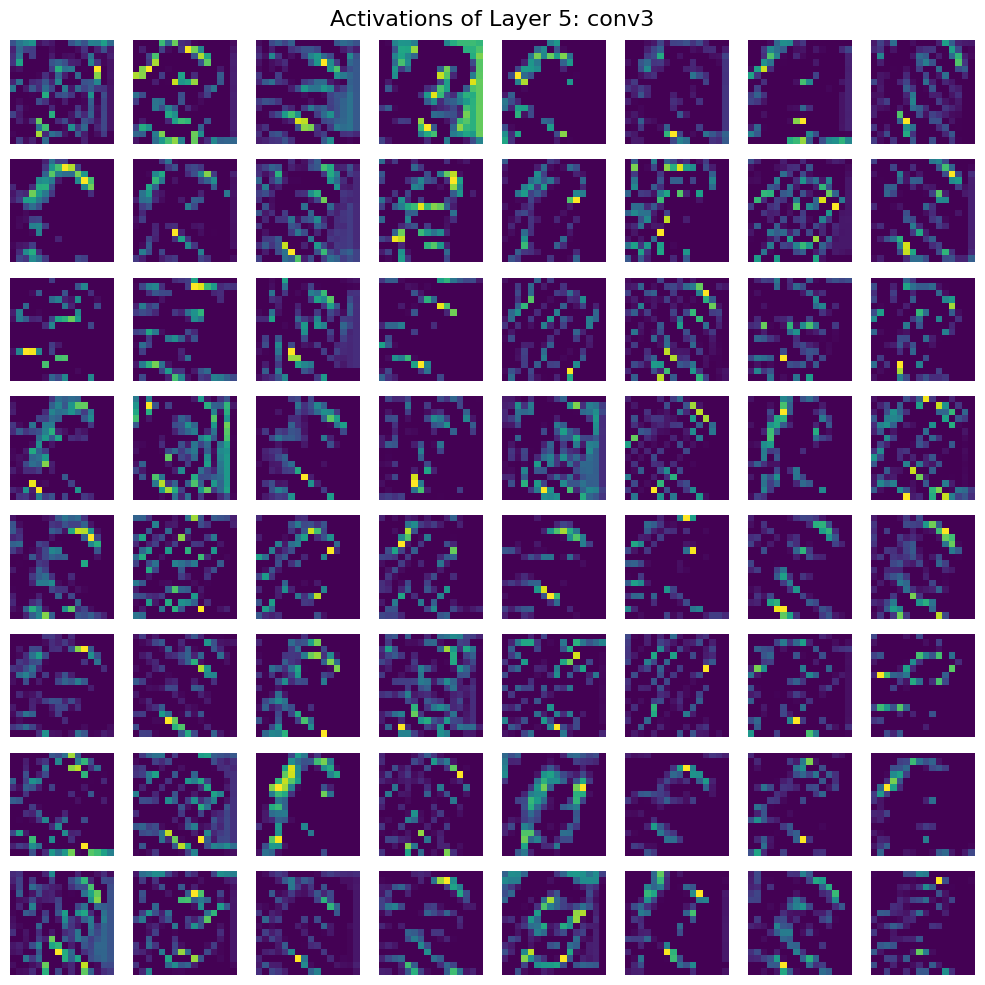

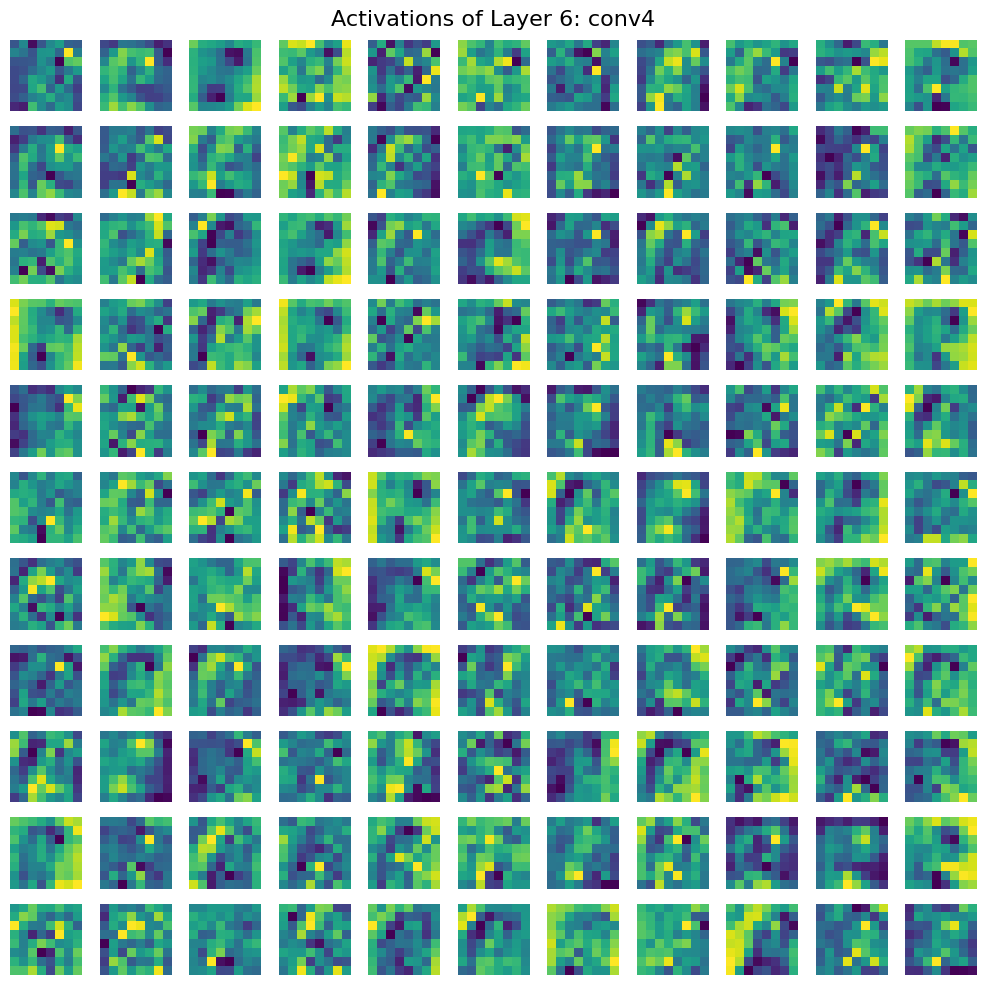

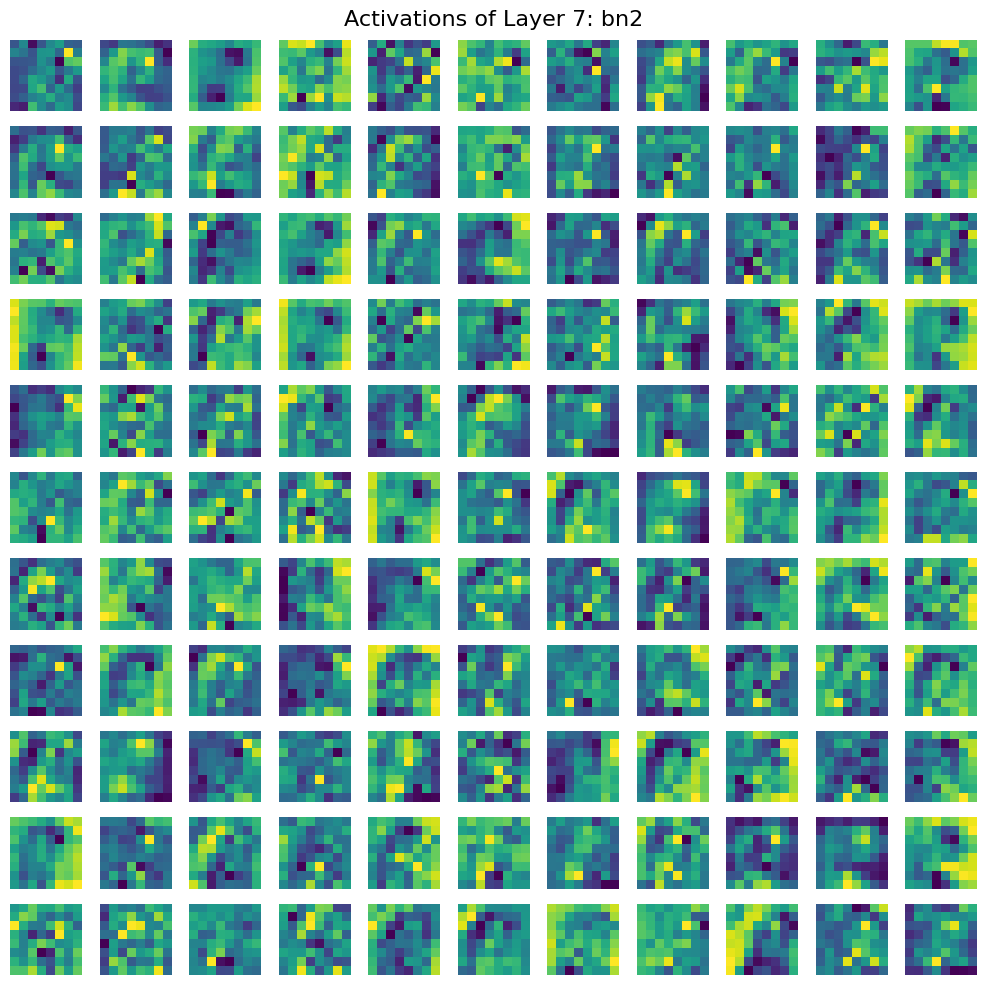

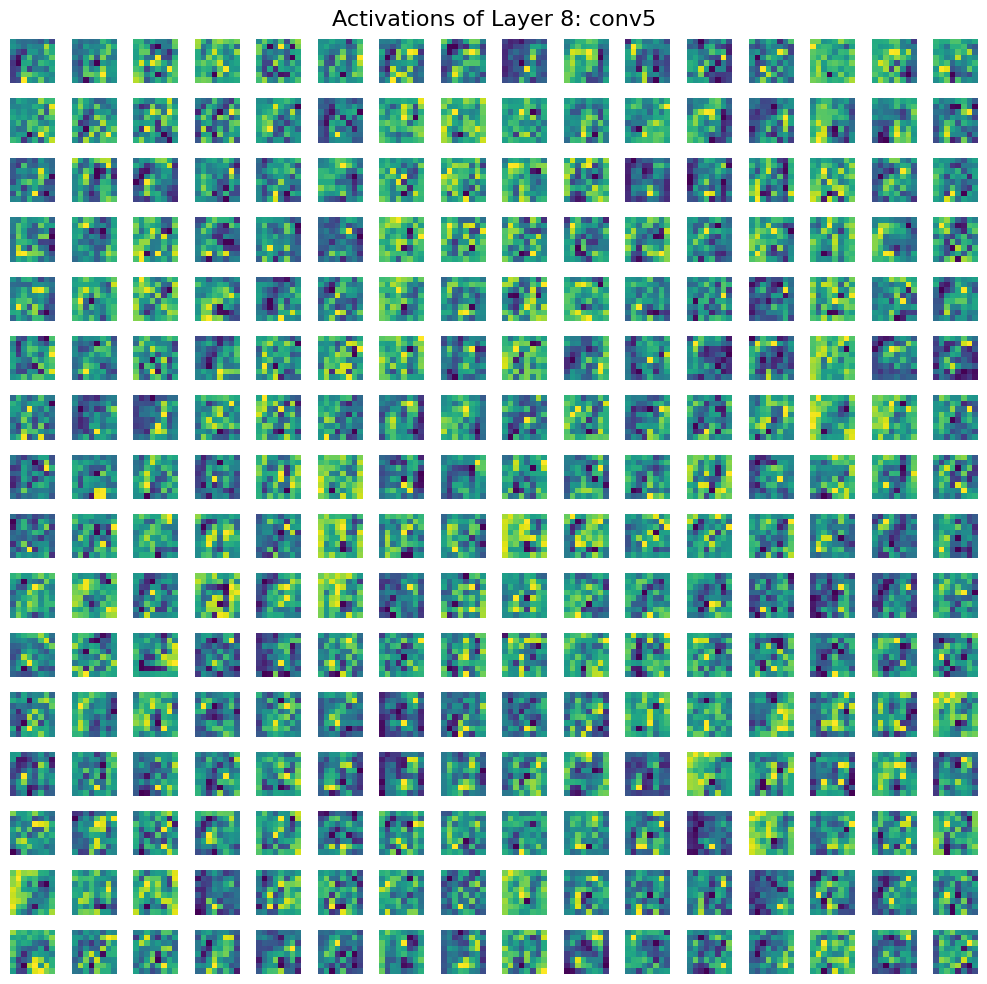

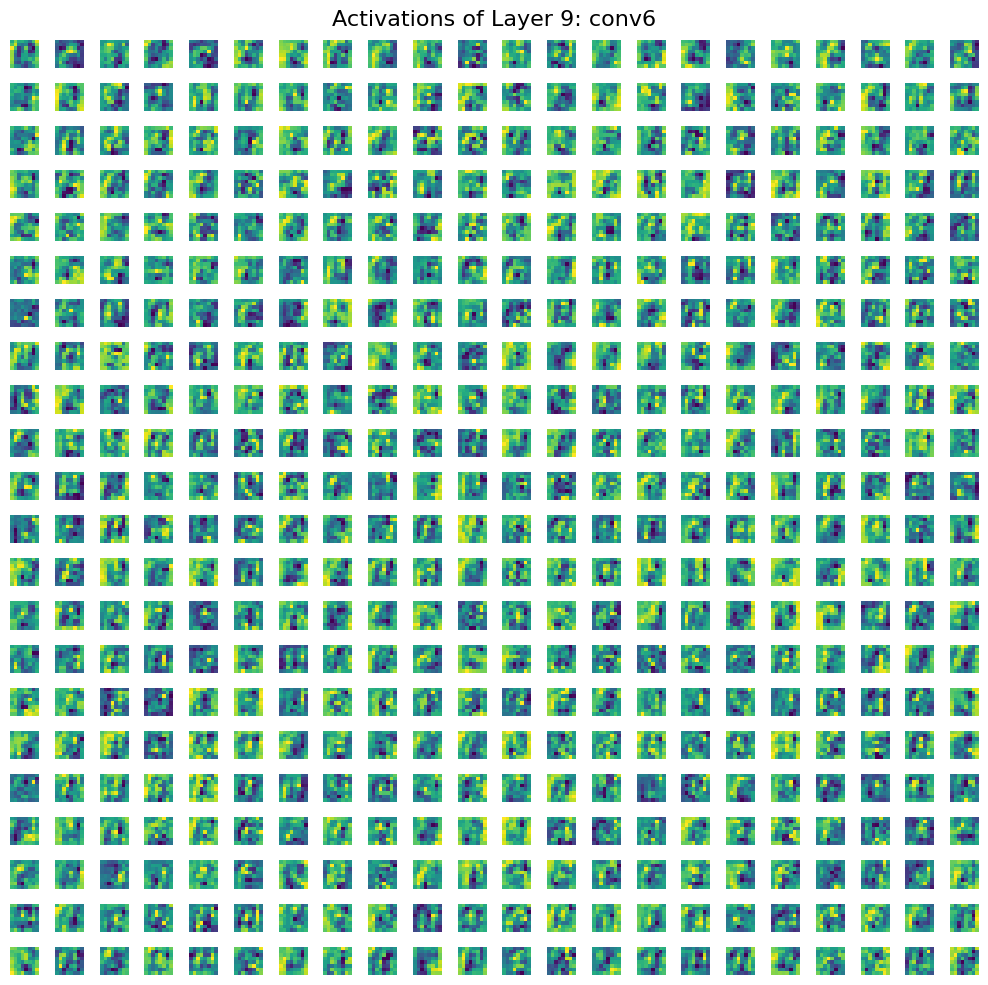

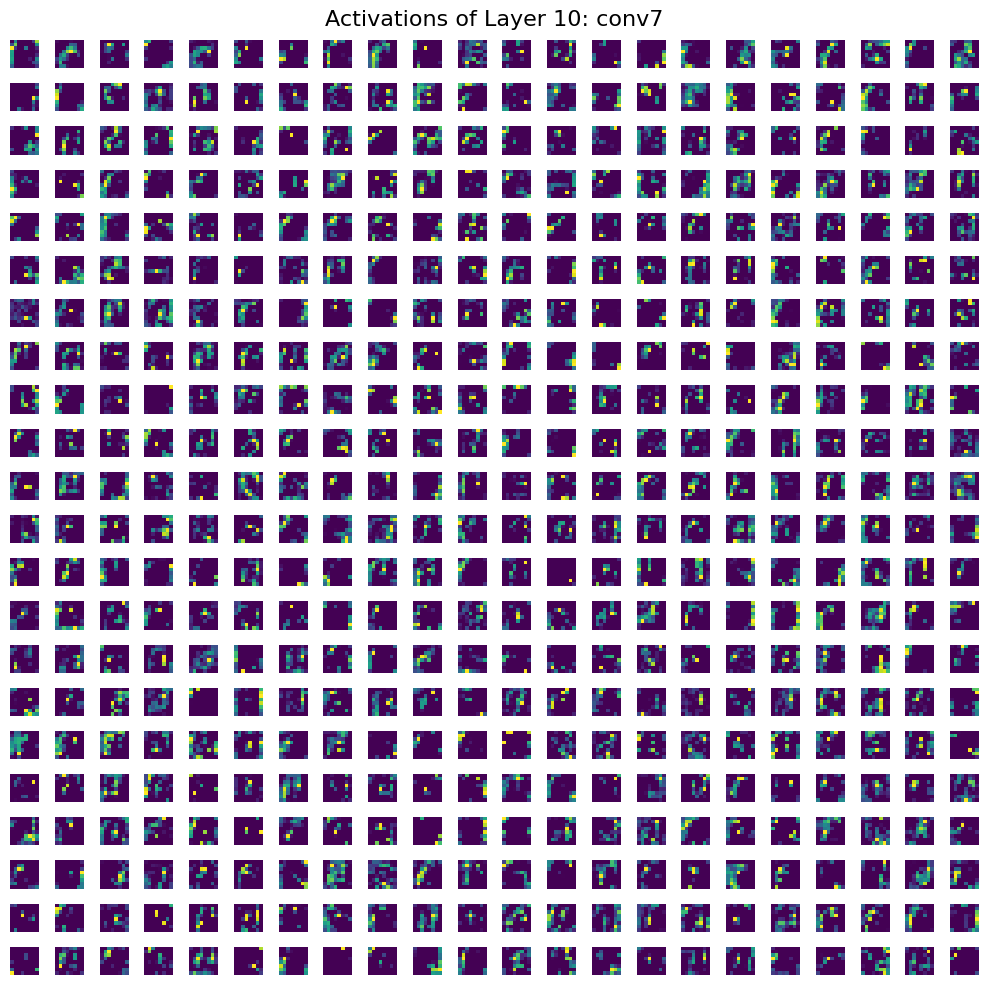

KeyboardInterrupt: 

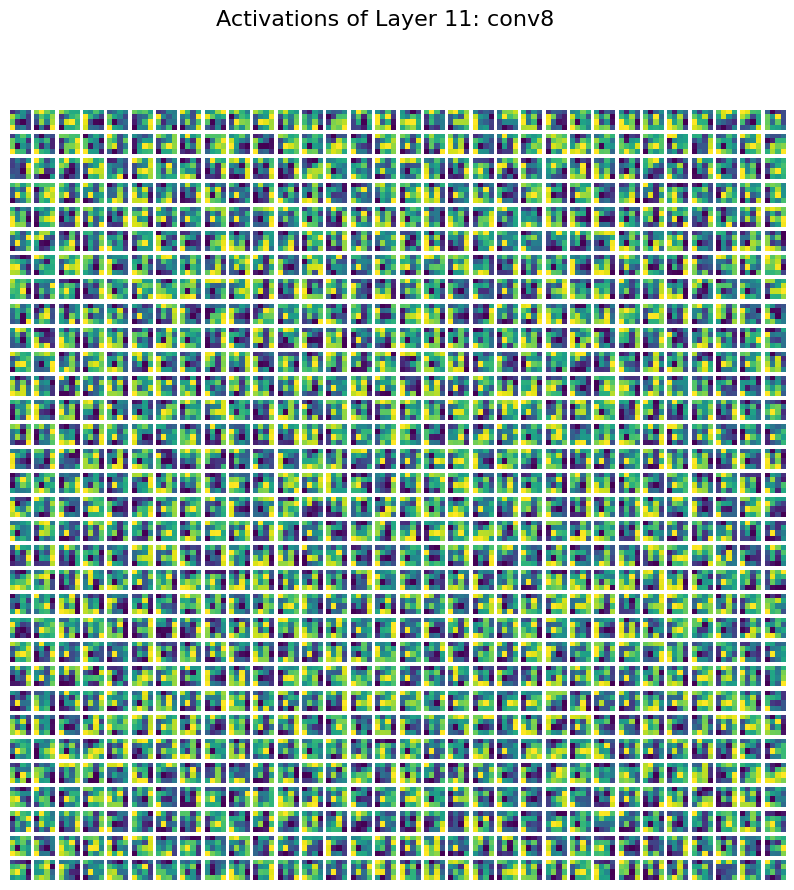

In [27]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is grayscale
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize grayscale images (adjust the values as needed)
])
input_image = transform(Image.open("rafid1.jpg")).unsqueeze(0).to(device)
plot_cnn_layer_activations(model, input_image)
